In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from tqdm.notebook import tqdm
import cv2
import os
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import time
import math
import matplotlib.pyplot as plt
from skimage import io, color


In [3]:
#function for calculating IoU, precision and recall between two masks

def IoU(result1,result2):
    
    result1 = result1>0.5
    result2 = result2>0.5

    contours1, hierarchy = cv2.findContours(result1.astype("uint8")*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours2, hierarchy = cv2.findContours(result2.astype("uint8")*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    intersection = np.logical_and(result1, result2)
    contoursi, hierarchy = cv2.findContours(intersection.astype("uint8")*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    union = np.logical_or(result1, result2)
    iou_score = np.sum(intersection) / np.sum(union)
    
    if(len(contours1)>0):
        precision = len(contoursi)/len(contours1)
    else:
        precision = 0
    if(len(contours2)>0):
        recall = len(contoursi)/len(contours2)
    else:
        recall = 0
    
    if(recall > 1):
        recall = 1
    if(precision > 1):
        precision = 1

  
    return iou_score, precision, recall

In [4]:
#definition of our dataset. Returns duos of normalized image + its segmentation mask

class EarDataset(Dataset):
    """Ear dataset."""

    def __init__(self, root_dir, transform=None, isValidation=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        img_dir = "train"
        annot_dir = "trainannot"
        if(isValidation):
            img_dir = "test"
            annot_dir = "testannot"
        
        self.data_img = []
        self.data_annot = []
        for img in os.listdir(root_dir + "/" + img_dir):
            if(img.split(".")[-1]=="png"):
                self.data_img.append(root_dir + "/" + img_dir + "/" + img)
        for img in os.listdir(root_dir + "/" + annot_dir):
            if(img.split(".")[-1]=="png"):
                self.data_annot.append(root_dir + "/" + annot_dir + "/" + img)

        self.transform = transform

    def __len__(self):
        return len(self.data_img)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = io.imread(self.data_img[idx])
        #print(image.dtype)
        annot = io.imread(self.data_annot[idx])*255
        
        if len(image.shape) == 2:
            image = image = color.gray2rgb(image)
        elif image.shape[2] == 4:
            image = image[:,:,:3]
        
        sizex = math.ceil(image.shape[1]/32)*8+14
        sizey = math.ceil(image.shape[0]/32)*8+14
        
        #image = cv2.resize(image,(480,480))
        annot = cv2.resize(annot,(sizex,sizey))


        image = image_transform(image)
        annot = annot_transform(annot)

        return image, annot

In [5]:
#our transforms from image to tensor

image_transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
annot_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(1),
        transforms.ToTensor()
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
#creating our dataset from images from given folder

path = "AWEForSegmentation"

datasetTrain = EarDataset(root_dir=path, isValidation=False)
datasetValid = EarDataset(root_dir=path, isValidation=True)


dataset_loader_train = torch.utils.data.DataLoader(datasetTrain,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
dataset_loader_valid = torch.utils.data.DataLoader(datasetValid,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)


In [7]:
#used to graph our losses

losses_train = []
losses_valid = []

In [8]:
#our training function. Runs training and validation for the given number of epochs. If validation=true, it will 
#skip the training part and only validate the model on the test set. The checkpoint with the highest IoU is saved
#to a file to load later

def train_model(model, criterion, optimizer, num_epochs=2, validation=False):
    since = time.time()

    highest_iou = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                if validation:
                    continue
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            print("Starting phase: ", phase)
                
            running_loss = 0.0
            running_iou = 0.0
            running_p = 0.0
            running_r = 0.0

            # Iterate over data.
            dataload = dataset_loader_train if phase == 'train' else dataset_loader_valid
            for j, stuff in enumerate(tqdm(dataload)):
                
                images, annots = stuff
                
                images = images.cuda()
                annots = annots.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, annots)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() #* images.size(0)
                #print('Runnning loss: {}'.format(running_loss))
                #running_corrects += torch.sum(preds == labels.data)
                pred_iou = 0.0
                for i in range(outputs.shape[0]):
                    pred = (outputs[i].cpu().sigmoid().detach().permute(1,2,0).numpy())[:,:,0]
                    ann = annots[i].cpu().detach().permute(1,2,0).numpy()[:,:,0]
                    iou,p,r = IoU(ann,pred)
                    running_iou += iou
                    running_p += p
                    running_r += r
                    
                #running_iou += pred_iou/outputs.shape[0]
                
                #print(running_iou/(j+1),j)
                
            epoch_loss = running_loss / len(dataload.dataset)
            epoch_iou = running_iou / len(dataload.dataset)
            epoch_p = running_p / len(dataload.dataset)
            epoch_r = running_r / len(dataload.dataset)
            if(phase == 'train'):
                losses_train.append(epoch_loss)
            else:
                losses_valid.append(epoch_loss)
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Iou: {:.4f} precision:{:.4f} recall:{:.4f}'.format(
                phase, epoch_loss, epoch_iou, epoch_p, epoch_r))
        
        if(epoch_iou > highest_iou):
            highest_iou = epoch_iou
            torch.save(net.state_dict(), 'checkpoint_resnet.pth')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [9]:
#our network. ResNet-50 with the last layer replaced with deconvolutional layers.

class Net(ResNet):

    def __init__(self):
        super(Net, self).__init__(Bottleneck, [3, 4, 6, 3])

        self.deconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2)
        self.debn1 = nn.BatchNorm2d(1024)

        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2)
        self.debn2 = nn.BatchNorm2d(512)

        self.deconv3 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2)
        self.debn3 = nn.BatchNorm2d(256)

        self.conv = nn.Conv2d(256, 1, kernel_size=1)



    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.relu(self.debn1(self.deconv1(x)))
        x = F.relu(self.debn2(self.deconv2(x)))
        x = F.relu(self.debn3(self.deconv3(x)))
        x = self.conv(x)

        return x

This part is for training of the model:

In [9]:
#Creating our network and loading the weights from a ResNet pretrained od ImageNet

net = Net()
net = net.cuda()

net_pretrained = torchvision.models.resnet50(pretrained=True)

criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)

pretrained_dict = net_pretrained.state_dict()
model_dict = net.state_dict()
#print(next(net_pretrained.parameters())[0])
#print(next(net.parameters())[0])

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
net.load_state_dict(pretrained_dict, strict = False)
#print(next(net.parameters())[0])

_IncompatibleKeys(missing_keys=['deconv1.weight', 'deconv1.bias', 'debn1.weight', 'debn1.bias', 'debn1.running_mean', 'debn1.running_var', 'deconv2.weight', 'deconv2.bias', 'debn2.weight', 'debn2.bias', 'debn2.running_mean', 'debn2.running_var', 'deconv3.weight', 'deconv3.bias', 'debn3.weight', 'debn3.bias', 'debn3.running_mean', 'debn3.running_var', 'conv.weight', 'conv.bias'], unexpected_keys=[])

In [10]:
#running the training for 15 epochs

#criterion = nn.BCEWithLogitsLoss().cuda()
#optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)

net = net.cuda()
net = train_model(net, criterion, optimizer, num_epochs=15)

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 0/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0315 Iou: 0.2305 precision:0.5756 recall:0.4617
Starting phase:  val


100%|██████████| 63/63 [00:05<00:00, 12.37it/s]


val Loss: 0.0169 Iou: 0.4191 precision:0.8280 recall:0.8467


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0125 Iou: 0.4649 precision:0.9040 recall:0.8994
Starting phase:  val


100%|██████████| 63/63 [00:05<00:00, 12.22it/s]


val Loss: 0.0100 Iou: 0.5062 precision:0.9240 recall:0.9420


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0083 Iou: 0.5127 precision:0.9344 recall:0.9343
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0076 Iou: 0.3050 precision:0.8020 recall:0.8380
Epoch 3/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0066 Iou: 0.5129 precision:0.9416 recall:0.9385
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0069 Iou: 0.4345 precision:0.8820 recall:0.9080
Epoch 4/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0054 Iou: 0.5535 precision:0.9582 recall:0.9468
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0076 Iou: 0.4753 precision:0.9740 recall:0.8550
Epoch 5/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0047 Iou: 0.5698 precision:0.9613 recall:0.9504
Starting phase:  val


100%|██████████| 63/63 [00:05<00:00, 12.21it/s]


val Loss: 0.0058 Iou: 0.5402 precision:0.9640 recall:0.9238


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0042 Iou: 0.5854 precision:0.9638 recall:0.9552
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0048 Iou: 0.4918 precision:0.9360 recall:0.9673
Epoch 7/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0038 Iou: 0.6003 precision:0.9667 recall:0.9636
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0046 Iou: 0.5308 precision:0.9400 recall:0.9347
Epoch 8/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0038 Iou: 0.5892 precision:0.9704 recall:0.9557
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0043 Iou: 0.5036 precision:0.9000 recall:0.9160
Epoch 9/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0038 Iou: 0.5842 precision:0.9598 recall:0.9402
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0052 Iou: 0.4918 precision:0.9520 recall:0.8857
Epoch 10/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0039 Iou: 0.5708 precision:0.9558 recall:0.9328
Starting phase:  val


100%|██████████| 63/63 [00:05<00:00, 12.20it/s]


val Loss: 0.0047 Iou: 0.5689 precision:0.9520 recall:0.9387


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0037 Iou: 0.5857 precision:0.9647 recall:0.9517
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0043 Iou: 0.5624 precision:0.9320 recall:0.9447
Epoch 12/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0032 Iou: 0.6218 precision:0.9793 recall:0.9663
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0039 Iou: 0.5628 precision:0.9320 recall:0.9393
Epoch 13/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0031 Iou: 0.6254 precision:0.9696 recall:0.9543
Starting phase:  val


  0%|          | 0/188 [00:00<?, ?it/s]

val Loss: 0.0038 Iou: 0.5679 precision:0.9020 recall:0.9300
Epoch 14/14
----------
Starting phase:  train


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.0030 Iou: 0.6290 precision:0.9762 recall:0.9644
Starting phase:  val


100%|██████████| 63/63 [00:05<00:00, 12.04it/s]

val Loss: 0.0046 Iou: 0.4596 precision:0.8260 recall:0.8560
Training complete in 12m 55s


This part is for validation of the best model:

In [16]:
#loading the network from file, which should corespond to the checkpoint that had the highest IoU during training

net = Net()
net = net.cuda()
net = net.eval()
checkpoint = torch.load("checkpoint_resnet_trained.pth")
net.load_state_dict(checkpoint)
torch.set_grad_enabled(False)


In [17]:
#running validation

criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0005)

train_model(net, criterion, optimizer, num_epochs=1, validation=True)

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 0/0
----------
Starting phase:  val


100%|██████████| 63/63 [00:04<00:00, 13.11it/s]


val Loss: 0.0047 Iou: 0.5689 precision:0.9520 recall:0.9387
Training complete in 0m 5s


Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),

  0%|          | 0/63 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/63 [00:00<?, ?it/s]

bool bool False
0.45384615384615384 1.0 1.0
bool bool False
0.3574144486692015 1.0 1.0
bool bool False
0.8559322033898306 1.0 1.0
bool bool False
0.2631578947368421 0.3333333333333333 1.0


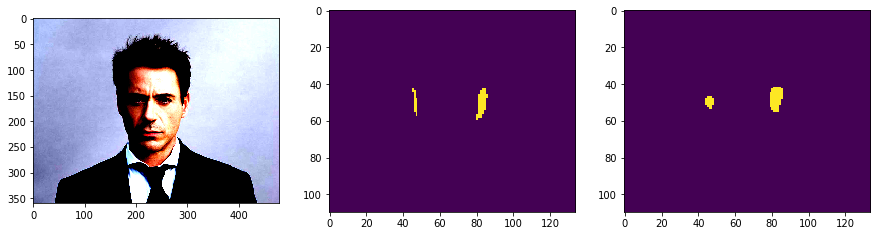

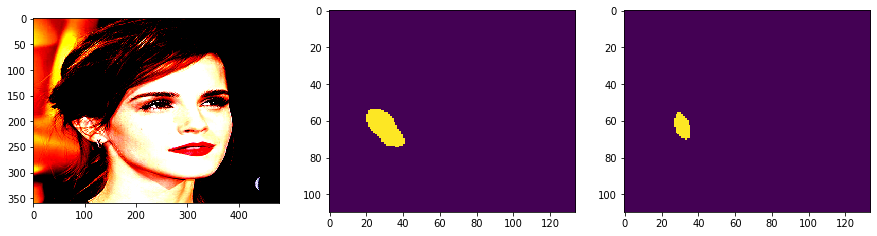

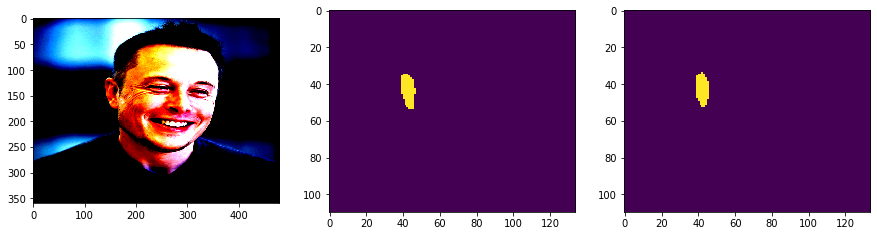

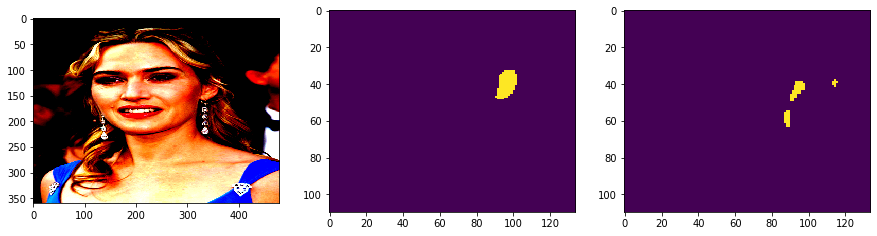

In [15]:
#running the model on a random batch of images from the dataset and displaying the results. First segmentation map
#is the annotation, second is the prediction

for images, annots in tqdm(dataset_loader_valid):
    out = net(images.cuda())
    for i in range(out.shape[0]):
        #print(annots[i].shape, images[i].shape,annots[i].cpu().detach().permute(1,2,0).numpy().shape)
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(images[i].cpu().detach().permute(1,2,0).numpy())
        ann = annots[i].cpu().detach().permute(1,2,0).numpy()[:,:,0]
        ann = ann > 0.5
        pred = (out[i].cpu().sigmoid().detach().permute(1,2,0).numpy())[:,:,0]
        pred = pred > 0.5
        plt.subplot(1,3,2)
        plt.imshow(ann)
        plt.subplot(1,3,3)
        plt.imshow(pred)
        #print(np.max(out[i].cpu().sigmoid().detach().permute(1,2,0).numpy()),np.min(out[i].cpu().detach().permute(1,2,0).numpy()))
        print(pred.dtype,ann.dtype,np.min(ann))
        jac, p, r = IoU(pred,ann)
        print(jac,p ,r)
        #cv2.waitKey(0)
        #break
    break